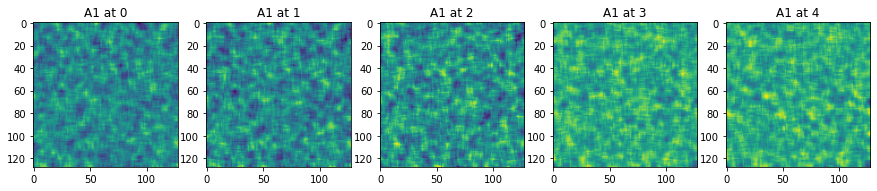

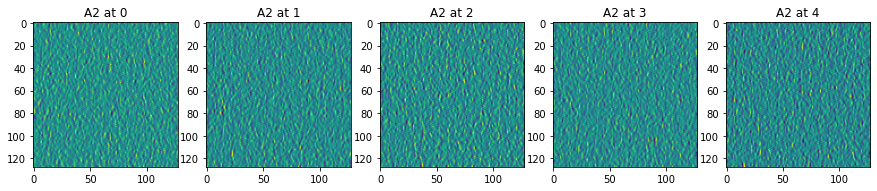

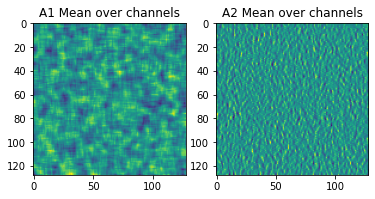

In [21]:
import numpy as np
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
%matplotlib inline
channels = 5
hw = 128

# Create some Activation tensors
A1 = np.random.randn(channels,hw,hw)
A2 = np.random.rand(channels,hw,hw)

# make one low frequency  
filt = np.ones((3,6,6))
filt = filt / np.sum(filt)
A1 = convolve(A1,filt)
A1 = A1 - np.mean(A1)

# make one high frequency
filt = np.ones((2,3,3))
filt = filt / np.sum(filt)
filt[:,:,0] = filt[:,:,0]*(-1)
filt[:,:,1] = 0
A2 = convolve(A2,filt)
A2 = A2 - np.mean(A2)

# plot each tensor, average along channel
def show_active(A,title=''):
    plt.imshow(np.mean(A,0))
    plt.title(title)

plt.figure(figsize=(15,5))   
for i in range(channels):
    plt.subplot(1,channels,i+1)
    plt.imshow(A1[i,:,:])
    plt.title(f'A1 at {i}')
    
plt.figure(figsize=(15,5))   
for i in range(channels):
    plt.subplot(1,channels,i+1)
    plt.imshow(A2[i,:,:])
    plt.title(f'A2 at {i}')
    
plt.figure()
plt.subplot(1,2,1)
show_active(A1,'A1 Mean over channels')
plt.subplot(1,2,2)
show_active(A2,'A2 Mean over channels')

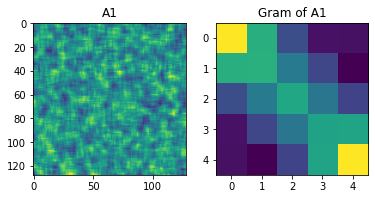

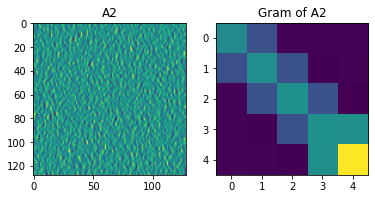

In [22]:
# calculate gram matrix (vectorized spatially) and show it
# for each activations
def gram(x):
    tmp = x.reshape((channels,hw*hw))
    return tmp @ tmp.T / (channels*hw*hw)

def show_gram(A,title=''):
    plt.figure()
    G = gram(A)
    plt.subplot(1,2,2)
    plt.imshow(G)
    plt.title('Gram of '+title)
    plt.subplot(1,2,1)
    show_active(A,title)
    

show_gram(A1,'A1')
show_gram(A2,'A2')

In order to whiten an output convolution (activation), we can use its SVD decomposition as follows:

$$ 
\begin{align}
A_f =& flatten(A) \\
A_f =& U\cdot\Sigma\cdot V^T \\
A_{wf} =& U\cdot V^T \\
A_{white} =& reshape(A_{wf}) \\
\end{align}
$$

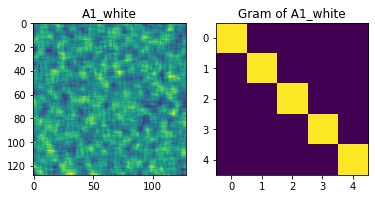

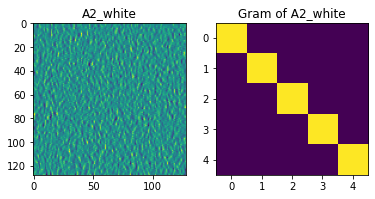

In [23]:
# apply whitening (get relevant SVD vectors)
def whiten(A):
    Avec = A.reshape((channels,hw*hw))
    u,s,vt = np.linalg.svd(Avec,full_matrices=False)
    A_white = (u @ vt).reshape((channels,hw,hw)) # no usage of the singular values here
    return A_white, (u, s, vt), Avec
    
A1_white, A1SVD, A1vec = whiten(A1)
A2_white, A2SVD, A2vec = whiten(A2)

show_gram(A1_white,'A1_white')
show_gram(A2_white,'A2_white')


Now we can transfer the covariances of the activations (i.e., the Grammian) from one matrix to another. This can be achieved in a few ways. The first is given by:

$$ 
\begin{align}
\widehat{A}_{c} =& flatten(A_c) &\widehat{A}_{s} =& flatten(A_s) \\
\widehat{A}_{c} =& U_c\cdot\Sigma_c\cdot V_c^T & \widehat{A}_{s} =& U_s\cdot\Sigma_s\cdot V_s^T \\
\widehat{A}_{s\leftarrow c} =& \underbrace{U_s\cdot\Sigma_s}_{\text{from s}}\underbrace{\cdot V_c^T}_{\text{from c}} &\widehat{A}_{c\leftarrow s} =& \underbrace{U_c\cdot\Sigma_c}_{\text{from c}}\underbrace{\cdot V_s^T}_{\text{from s}} \\
A_{s\leftarrow c} =& reshape(\widehat{A}_{s\leftarrow c}) & A_{c\leftarrow s} =& reshape(\widehat{A}_{c\leftarrow sf}) \\
\end{align}
$$

A1 average content difference: 0.007284655482131243
A2 average content difference: 0.007284655482131254


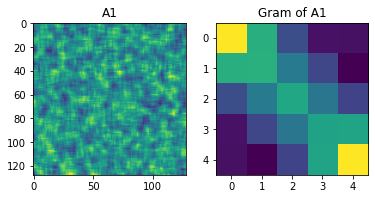

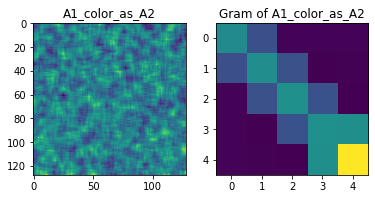

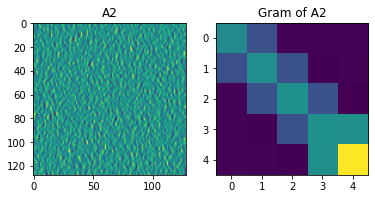

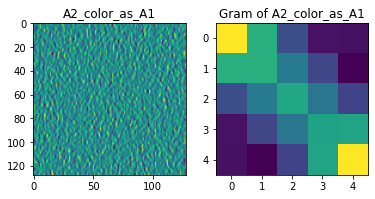

In [24]:
u1, s1, v1 = A1SVD
u2, s2, v2 = A2SVD

# Apply coloring
A1_color_as_A2 = (u2 @ np.diag(s2) @ v1).reshape((channels,hw,hw))
A2_color_as_A1 = (u1 @ np.diag(s1) @ v2).reshape((channels,hw,hw))

# show originals
# and colored versions
diffA1 = np.mean((A1_color_as_A2-A1)**2)
diffA2 = np.mean((A2_color_as_A1-A2)**2)

print('A1 average content difference:', diffA1)
print('A2 average content difference:', diffA2)

show_gram(A1,'A1')
show_gram(A1_color_as_A2,'A1_color_as_A2')

show_gram(A2,'A2')
show_gram(A2_color_as_A1,'A2_color_as_A1')

____
Now, there is a (potentially) slight problem with the matrices above. The colored matrices have the exact Grammian that we want, but do we want the Grammian matrices to be identical? What if that causes some image artifacts of transfer too much style into the activations? Would it be better if we only partially colored the matrices such that the Grammian were more mixed? The answer is not immediately clear, but we have the math to test it out.  This partial coloring can be achieved using the eigen decomposition. Notice that the right eigenvectors (V) are not used at all in this decomposition. 

$$ 
\begin{align}
Af_{c} =& flatten(A_c) & Af_{s} =& flatten(A_s) \\
\widehat{Af}_{c} =& U_c\cdot\frac{1}{\sqrt{\Sigma_c}}\cdot U_c^T \cdot Af_{c} &
\widehat{Af}_{s} =& U_s\cdot\frac{1}{\sqrt{\Sigma_s}}\cdot U_s^T \cdot Af_{s} \\
\widehat{A}_{s\leftarrow\approx c} =& U_s\cdot\frac{1}{\sqrt{\Sigma_s}}\cdot U_s^T \cdot \widehat{Af}_{c}   &
\widehat{A}_{c\leftarrow\approx s} =& U_c\cdot\frac{1}{\sqrt{\Sigma_c}}\cdot U_c^T \cdot \widehat{Af}_{s}  \\
A_{s\leftarrow\approx c} =& reshape(\widehat{A}_{s\leftarrow\approx c}) & A_{c\leftarrow\approx s} =& reshape(\widehat{A}_{c\leftarrow\approx sf}) \\
\end{align}
$$

A1 average content difference: 0.010314925381414913
A2 average content difference: 0.0030819890758886533


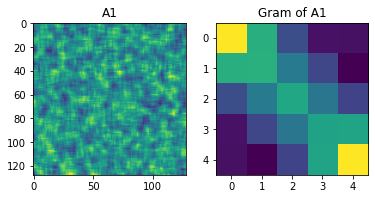

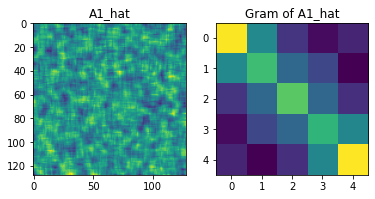

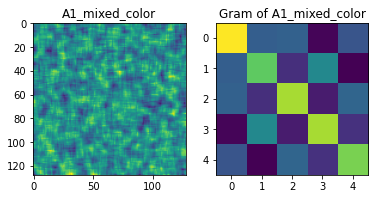

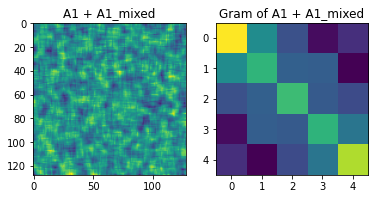

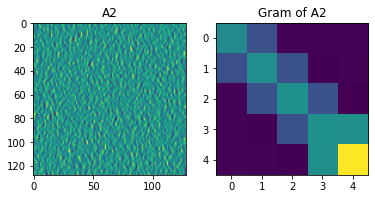

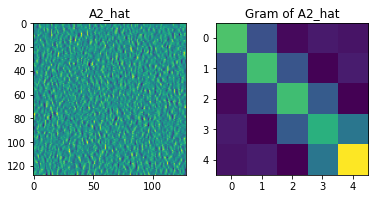

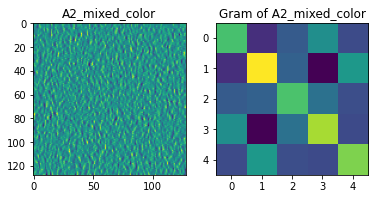

In [28]:
u1, s1, _ = A1SVD
u2, s2, _ = A2SVD

# -------A1-------
# Apply approximation to get slightly whitened version of A1
A1hat = u1 @ np.diag(s1**(-0.5)) @ u1.T @ A1vec
# Apply inverse reconstruction to get partially colored version
A1_mixed_color = u2 @ np.diag(s2**(-0.5)) @ u2.T @ A1hat
A1_mixed_color = A1_mixed_color.reshape((channels,hw,hw))

# -------A2-------
# Apply approximation to get slightly whitened version of A2
A2hat = u2 @ np.diag(s2**(-0.5)) @ u2.T @ A2vec
# Apply inverse reconstruction to get partially colored version
A2_mixed_color = u1 @ np.diag(s1**(-0.5)) @ u1.T @ A2hat
A2_mixed_color = A2_mixed_color.reshape((channels,hw,hw))

diffA1 = np.mean((A1_mixed_color-A1)**2)
diffA2 = np.mean((A2_mixed_color-A2)**2)

print('A1 average content difference:', diffA1)
print('A2 average content difference:', diffA2)

# show originals
# and colored versions
show_gram(A1,'A1')
show_gram(A1hat.reshape((channels,hw,hw)),'A1_hat')
show_gram(A1_mixed_color,'A1_mixed_color')

# show originals
# and colored versions
show_gram(A2,'A2')
show_gram(A2hat.reshape((channels,hw,hw)),'A2_hat')
show_gram(A2_mixed_color,'A2_mixed_color')

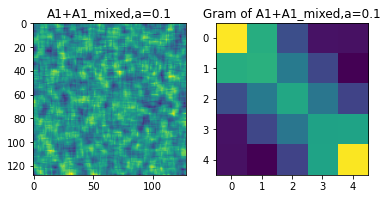

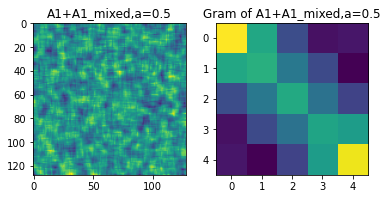

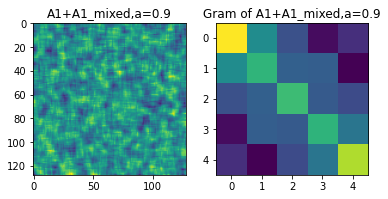

In [35]:
# Another trick we can use to insert more content
# back into the matrix is to take a weighted sum
# of the colored contetn and original content 
for alpha in [0.1, 0.5, 0.9]:
    show_gram(alpha*A1_mixed_color+(1-alpha)*A1,f'A1+A1_mixed,a={alpha}')
